# Inference of TNF pathway

In [1]:
import os
import string

import chi
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
sns.set_theme()

The data-generating model is a hierarchical tumour necrosis factor model
(Chaves et al., 2008) governed by

$$
    p(y, \psi | \theta , t) = p(y | \psi , t)\, p(\psi | \theta),
$$

where $\psi$ are the bottom-level parameters and
$\theta$ are the top-level parameters.
The measurements of individuals are governed by a distribution defined by the
mechanistic model-error model pair

$$
    p(y | \psi , t) =
        \mathrm{LN}\left( y | \log \bar{y}(\psi, t), \sigma \right)
$$

with $\bar{y} = c_a$ models the concentration of activated cell receptors which
is described by

$$
    \frac{\mathrm{d}c_8}{\mathrm{d}t} =
        -k^{\mathrm{off}}_{8} c_8 + k^{\mathrm{on}}_{8, \mathrm{tnf}} \frac{d^2_{8, \mathrm{nf}}}{c_{\mathrm{nf}}^2 + d^2_{8, \mathrm{nf}}} \frac{c^2_{\mathrm{tnf}}}{c_{\mathrm{tnf}}^2 + a^2_{8, \mathrm{tnf}}} + k^{\mathrm{on}}_{8, 3}  \frac{c^2_{3}}{c_{3}^2 + a^2_{8, 3}}\\
    \frac{\mathrm{d}c_3}{\mathrm{d}t} =
        -k^{\mathrm{off}}_{3} c_3 + k^{\mathrm{on}}_{3} \frac{d^2_{3, \mathrm{nf}}}{c_{\mathrm{nf}}^2 + d^2_{3, \mathrm{nf}}} \frac{c^2_{8}}{c_{8}^2 + a^2_{3, 8}}\\
    \frac{\mathrm{d}c_{\mathrm{nf}}}{\mathrm{d}t} =
        -k^{\mathrm{off}}_{\mathrm{nf}} c_{\mathrm{nf}} + k^{\mathrm{on}}_{\mathrm{nf}} \frac{d^2_{\mathrm{nf}, 3}}{c_{3}^2 + d^2_{\mathrm{nf}, 3}} \frac{d^2_{\mathrm{nf}, \mathrm{inf}}}{c_{\mathrm{inf}}^2 + d^2_{\mathrm{nf}, \mathrm{inf}}}\\
    \frac{\mathrm{d}c_{\mathrm{inf}}}{\mathrm{d}t} =
        -k^{\mathrm{off}}_{\mathrm{inf}} c_{\mathrm{inf}} + k^{\mathrm{on}}_{\mathrm{inf}, \mathrm{tnf}} \frac{d^2_{\mathrm{inf}, \mathrm{tnf}}}{c_{\mathrm{tnf}}^2 + d^2_{\mathrm{inf}, \mathrm{tnf}}} + k^{\mathrm{on}}_{\mathrm{inf}, \mathrm{nf}} \frac{c_{\mathrm{nf}}^2}{c_{\mathrm{nf}}^2 + a^2_{\mathrm{inf}, \mathrm{nf}}}\\
    \frac{\mathrm{d}a_{\mathrm{tnf}}}{\mathrm{d}t} = -k_e a_{\mathrm{tnf}} + r(t)\quad \mathrm{and} \quad c_{\mathrm{tnf}} = \frac{a_{\mathrm{tnf}}}{v}
$$
with initial conditions $c_8(t=0) = c_3(t=0) = 0$, $c_{\mathrm{nf}}(t=0) = 0.26$, and $c_{\mathrm{tnf}}(t=0) = 0.625$. Analogously to Hasenauer et al., we fix $k^{\mathrm{off}}_{8} = k^{\mathrm{off}}_{3} = k^{\mathrm{off}}_{\mathrm{nf}} = k^{\mathrm{off}}_{\mathrm{inf}} = k^{\mathrm{on}}_{3} = k^{\mathrm{on}}_{\mathrm{nf}} = 1$ and $k^{\mathrm{on}}_{8, \mathrm{tnf}} = k^{\mathrm{on}}_{8, 3} = k^{\mathrm{on}}_{\mathrm{inf}, \mathrm{tnf}} = k^{\mathrm{on}}_{\mathrm{inf}, \mathrm{nf}} = 0.5$.

Similar to Hasenauer et al., we administer TNF during $t\in [0, 2]$. Hasenauer et al. set TNF to a constant level of $c_{\mathrm{tnf}}=1$ during this interval, and set the TNF concentration to zero otherwise. To recreate this concentration profile, we fix $a_{\mathrm{tnf}}(t=0) = 1$, $v=1$, $k_e = 100$ and infuse TNF at a constant rate of $r_0 = 100$ from $t=0$ to $t=2$.

The inter-individual variability is governed by the population model

$$
    p(\psi | \theta) =
        \mathcal{N}(p | \mu_{p}, \sigma ^2_{p})\,
        \mathcal{N}(k_{\mathrm{on}} | \mu_{k_{\mathrm{on}}}, \sigma ^2_{k_{\mathrm{on}}})\,
        \delta (k_{\mathrm{off}} - \theta_{k_{\mathrm{off}}})\,
        \delta (k_{\mathrm{deg}, r} - \theta_{k_{\mathrm{deg}, r}})\,
        \delta (k_{\mathrm{deg}, a} - \theta_{k_{\mathrm{deg}, a}})\,
        \delta (\sigma - \theta_{\sigma}).
$$

### Results

Import results

In [2]:
# Import data
directory = os.getcwd()
measurements_df = pd.read_csv(directory + '/data/1_tnf_pathway_data.csv')

# Reshape data to numpy array of shape (n_ids_per_t, n_output, n_times)
n_ids_per_t = 500
output = 'Caspase 3 concentration'
n_outputs = 1
times = np.sort(measurements_df.Time.dropna().unique())
measurements = np.empty(shape=(n_ids_per_t, n_outputs, len(times)))
temp = measurements_df[measurements_df.Observable == output]
for idt, time in enumerate(times):
    mask = temp.Time == time
    measurements[:, 0, idt] = temp[mask].Value.values

# # Define true parameters
# true_arameters = [
#     1.7,    # Mean activation rate
#     0.05,   # Std. activation rate
#     8,      # deactivation rate
#     0.015,  # degradation rate (active)
#     0.25,   # degradation rate (inactive)
#     1.7,    # Mean production rate
#     0.05,   # Std. production rate
#     0.05,  # Sigma act. ligand conc. Amount 1
#     0.05,  # Sigma inact. ligand conc. Amount 1
#     0.05,  # Sigma act. ligand conc. Amount 2
#     0.05]  # Sigma inact. ligand conc. Amount 2

# # Define predictive model
# mechanistic_model = GrowthFactorModel()
# error_models = [
#     chi.LogNormalErrorModel(),  # Active ligand concentration Amount 1
#     chi.LogNormalErrorModel(),  # Inactive ligand concentration Amount 1
#     chi.LogNormalErrorModel(),  # Active ligand concentration Amount 1
#     chi.LogNormalErrorModel()]  # Inactive ligand concentration Amount 1
# predictive_model = chi.PredictiveModel(mechanistic_model, error_models)

# # Define population model
# population_model = chi.ComposedPopulationModel([
#     chi.GaussianModel(dim_names=['Activation rate'], centered=True),
#     chi.PooledModel(n_dim=3, dim_names=[
#         'Deactivation rate', 'Deg. rate (act.)', 'Deg. rate (inact.)']),
#     chi.GaussianModel(dim_names=['Production rate'], centered=True),
#     chi.PooledModel(n_dim=4, dim_names=[
#         'Sigma act. ligand conc. Amount 1',
#         'Sigma inact. ligand conc. Amount 1',
#         'Sigma act. ligand conc. Amount 2',
#         'Sigma inact. ligand conc. Amount 2']),
#     chi.PooledModel(dim_names=['Sigma'])])

# Import NLME inference results
results = xr.load_dataset(
    directory + '/posteriors/filter_inference_tnf_pathway.nc')

In [20]:
import arviz as az

results

<xarray.Dataset>
Dimensions:                                                                  (
                                                                              chain: 1,
                                                                              draw: 1000,
                                                                              individual: 100)
Coordinates:
  * chain                                                                    (chain) int64 ...
  * draw                                                                     (draw) int64 ...
  * individual                                                               (individual) object ...
Data variables: (12/19)
    Pooled myokit.half_maximal_effect_concentration_c3_c8                    (chain, draw) float64 ...
    Pooled myokit.half_maximal_effect_concentration_c8_c3                    (chain, draw) float64 ...
    Pooled myokit.half_maximal_effect_concentration_c8_tnf                   (chain, draw) float64 ...
    Mean myokit.half_maximal_inhibitory_concentration_c3_nf                  (chain, draw) float64 ...
    Std. myokit.half_maximal_inhibitory_concentration_c3_nf                  (chain, draw) float64 ...
    Mean myokit.half_maximal_inhibitory_concentration_c3_nf Shift apoptotic  (chain, draw) float64 ...
    ...                                                                       ...
    myokit.half_maximal_inhibitory_concentration_inf_nf                      (chain, draw, individual) float64 ...
    myokit.caspase_3 Epsilon time 1                                          (chain, draw, individual) float64 ...
    myokit.caspase_3 Epsilon time 2                                          (chain, draw, individual) float64 ...
    myokit.caspase_3 Epsilon time 3                                          (chain, draw, individual) float64 ...
    myokit.caspase_3 Epsilon time 4                                          (chain, draw, individual) float64 ...
    myokit.caspase_3 Epsilon time 5                                          (chain, draw, individual) float64 ...
Attributes:
    divergent iterations:          true
    divergent iterations chain 0:  [   2    3    4 ... 1498 1499 1500]

Visualise results

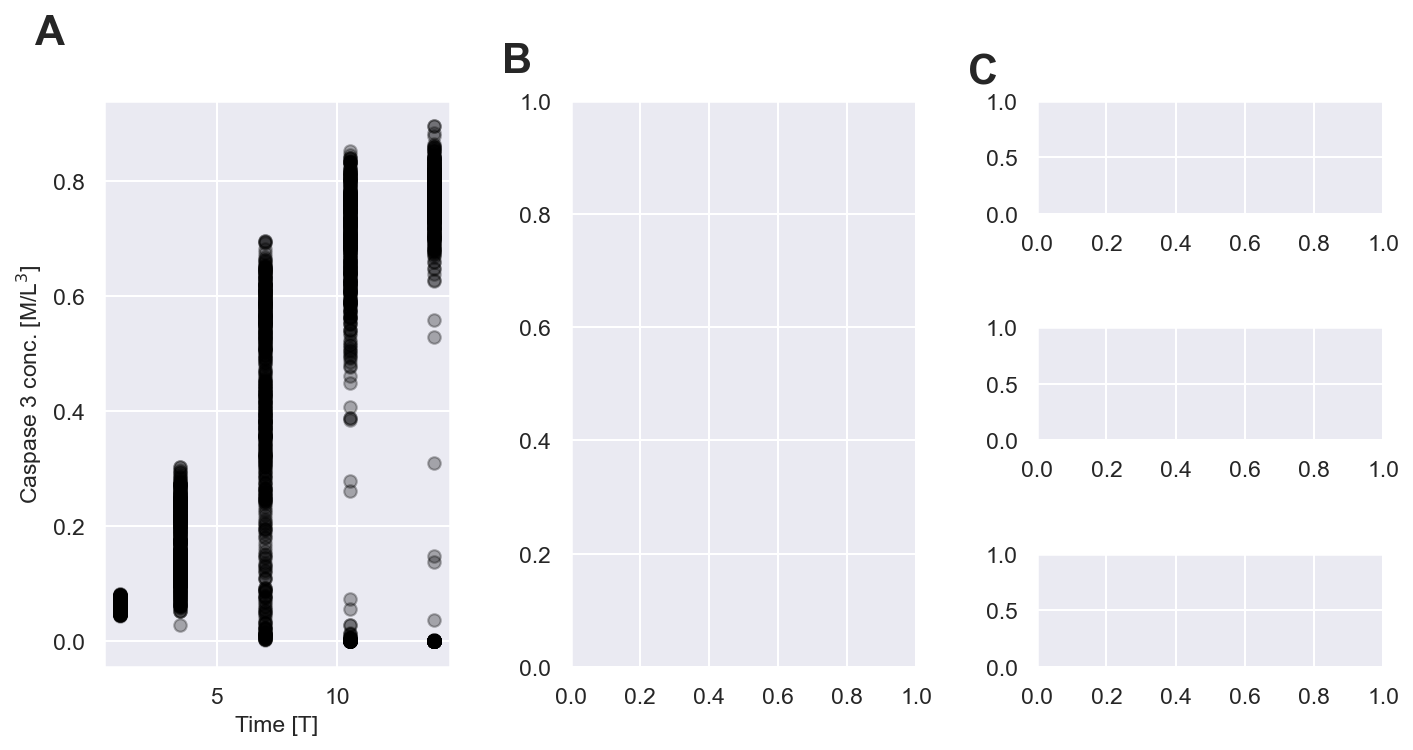

In [3]:
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 1000 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 3, wspace=0.35)

# Create time series axes
ax1 = plt.Subplot(fig, outer[0])
time_series_axes = [ax1]

# Create axis for IIV parameters
ax3 = plt.Subplot(fig, outer[1])

# Create axes for pooled parameters
inner = gridspec.GridSpecFromSubplotSpec(
    3, 1, subplot_spec=outer[2], hspace=1)
ax4 = plt.Subplot(fig, inner[0])
ax5 = plt.Subplot(fig, inner[1])
ax6 = plt.Subplot(fig, inner[2])
param_axes = [ax3, ax4, ax5, ax6]

# Add axes to figure
for ax in (time_series_axes + param_axes):
    fig.add_subplot(ax)

# # Define population model (central parametrisation)
# population_model = chi.ComposedPopulationModel([
#     chi.GaussianModel(dim_names=['Activation rate']),
#     chi.PooledModel(n_dim=3, dim_names=[
#         'Deactivation rate', 'Deg. rate (act.)', 'Deg. rate (inact.)']),
#     chi.GaussianModel(dim_names=['Production rate'])])

# # Plot population filter inference results (parameter space)
# seed = np.random.default_rng(3)
# n_samples = 5000
# parameters = np.vstack([
#     results['Mean myokit.activation_rate'].values.flatten(),
#     results['Std. myokit.activation_rate'].values.flatten(),
#     results['Pooled myokit.deactivation_rate'].values.flatten(),
#     results[
#         'Pooled myokit.degradation_rate_active_receptor'].values.flatten(),
#     results[
#         'Pooled myokit.degradation_rate_inactive_receptor'].values.flatten(),
#     results['Mean myokit.production_rate'].values.flatten(),
#     results['Std. myokit.production_rate'].values.flatten()]).T
# parameters = parameters[
#     np.random.choice(np.arange(len(parameters)), size=n_samples, replace=True)]
# samples = np.empty(shape=(n_samples, 5))
# for ids, params in enumerate(parameters):
#     samples[ids, :] = population_model.sample(params, seed=seed)[0]
# sns.kdeplot(
#     x=samples[:, 0], y=samples[:, 4], fill=True, bw_adjust=1.5,
#     levels=[0.2, 0.4, 0.6, 0.8, 1], ax=param_axes[0])
# sns.kdeplot(
#     x=samples[:, 1], fill=True, ax=param_axes[1])
# sns.kdeplot(
#     x=samples[:, 2], fill=True, ax=param_axes[2])
# sns.kdeplot(
#     x=samples[:, 3], fill=True, ax=param_axes[3])

# # Plot population filter inference results (measurement space)
# times = np.linspace(0.1, 25, 100)
# n_times = len(times)
# predictive_model = chi.PredictiveModel(mechanistic_model, error_models)
# simulated_measurements = np.empty(shape=(n_samples, 4, n_times))
# parameters = np.empty(shape=(n_samples, 9))
# parameters[:, :5] = samples
# parameters[:, 5] = true_arameters[-4]
# parameters[:, 6] = true_arameters[-3]
# parameters[:, 7] = true_arameters[-2]
# parameters[:, 8] = true_arameters[-1]
# for ids, sample in enumerate(parameters):
#     simulated_measurements[ids, :] = predictive_model.sample(
#         parameters=sample, times=times, seed=seed, return_df=False)[..., 0]
# fifth_percentile = np.percentile(simulated_measurements, q=5, axis=0)
# ninetyfifth_percentile = np.percentile(simulated_measurements, q=95, axis=0)
# time_series_axes[0].plot(
#     times, fifth_percentile[1], color=plt.get_cmap('Blues_r')(0))
# time_series_axes[0].plot(
#     times, ninetyfifth_percentile[1], color=plt.get_cmap('Blues_r')(0))
# time_series_axes[0].fill_between(
#     times, fifth_percentile[1], ninetyfifth_percentile[1],
#     color=plt.get_cmap('Blues_r')(1), alpha=0.5)
# time_series_axes[0].plot(
#     times, fifth_percentile[3], color=plt.get_cmap('Reds_r')(10))
# time_series_axes[0].plot(
#     times, ninetyfifth_percentile[3], color=plt.get_cmap('Reds_r')(10))
# time_series_axes[0].fill_between(
#     times, fifth_percentile[3], ninetyfifth_percentile[3],
#     color=plt.get_cmap('Reds_r')(10), alpha=0.5)
# time_series_axes[1].plot(
#     times, fifth_percentile[0], color=plt.get_cmap('Blues_r')(0))
# time_series_axes[1].plot(
#     times, ninetyfifth_percentile[0], color=plt.get_cmap('Blues_r')(0))
# time_series_axes[1].fill_between(
#     times, fifth_percentile[0], ninetyfifth_percentile[0],
#     color=plt.get_cmap('Blues_r')(0), alpha=0.5)
# time_series_axes[1].plot(
#     times, fifth_percentile[2], color=plt.get_cmap('Reds_r')(10))
# time_series_axes[1].plot(
#     times, ninetyfifth_percentile[2], color=plt.get_cmap('Reds_r')(10))
# time_series_axes[1].fill_between(
#     times, fifth_percentile[2], ninetyfifth_percentile[2],
#     color=plt.get_cmap('Reds_r')(10), alpha=0.5)

# # Plot data-generating distribution as reference to parameter space
# samples = population_model.sample(
#     true_arameters[:-4], n_samples, seed)
# sns.kdeplot(
#     x=samples[:, 0], y=samples[:, 4], fill=False, bw_adjust=1.5, color='black',
#     levels=[0.2, 0.4, 0.6, 0.8, 1], ax=param_axes[0], linestyles='solid')
# param_axes[1].axvline(x=true_arameters[2], color='black', linestyle='solid')
# param_axes[2].axvline(x=true_arameters[3], color='black', linestyle='solid')
# param_axes[3].axvline(x=true_arameters[4], color='black', linestyle='solid')

# Plot measurement used for the inference as reference
times = np.array([1, 3.5, 7, 10.5, 14])
for idm, meas in enumerate(measurements):
    time_series_axes[0].scatter(
        times, meas[0], color='black', marker='o', alpha=0.3)

# Label axes
time_series_axes[0].set_xlabel('Time [T]', fontsize=fontsize)
time_series_axes[0].set_ylabel(r'Caspase 3 conc. [M/L$^3$]', fontsize=fontsize)
# time_series_axes[1].set_ylabel('Active conc. [ng/mL]', fontsize=fontsize)
# time_series_axes[0].tick_params(labelsize=fontsize)
# time_series_axes[1].tick_params(labelsize=fontsize)
# time_series_axes[0].scatter(
#     [10, 10], [100, 101], color='black', linestyle='solid', marker='o',
#     label='Data (low)')
# time_series_axes[0].scatter(
#     [10, 10], [100, 101], color='black', linestyle='solid', marker='x',
#     label='Data (high)')
# time_series_axes[0].plot(
#     [10, 10], [100, 101], color=plt.get_cmap('Blues_r')(0),
#     linestyle='solid', label='Post. (low)')
# time_series_axes[0].plot(
#     [10, 10], [100, 101], color=plt.get_cmap('Reds_r')(0),
#     linestyle='solid', label='Post. (high)')
# time_series_axes[0].set_xlim([-1, 27])
# time_series_axes[0].set_ylim([-0.25, 9.9])
# time_series_axes[1].set_ylim([-0.25, 13.9])
# param_axes[0].plot(
#     [10, 10], [100, 101], color='black', label='True', linestyle='--')
# param_axes[0].plot(
#     [10, 10], [100, 101], color=plt.get_cmap('Blues_r')(0),label='Inferred')
# param_axes[1].plot(
#     [8, 8], [100, 101], color='black', label='True', linestyle='--')
# param_axes[1].plot(
#     [8, 8], [100, 101], color=plt.get_cmap('Blues_r')(0),label='Inferred')
# param_axes[0].set_xlim([1.57, 1.85])
# param_axes[0].set_ylim([1.59, 1.83])
# param_axes[1].set_ylim([0, 4.99])
# param_axes[0].set_xlabel('Activation rate [mL/ng/min]', fontsize=fontsize)
# param_axes[0].set_ylabel('Production rate [ng/mL/min]', fontsize=fontsize)
# param_axes[0].tick_params(labelsize=fontsize)
# param_axes[1].set_xlabel('Deactivation rate [1/min]', fontsize=fontsize)
# param_axes[1].set_ylabel('Density', fontsize=fontsize)
# param_axes[1].tick_params(labelsize=fontsize)
# param_axes[2].set_xlabel('Degrad. rate (act.) [1/min]', fontsize=fontsize)
# param_axes[2].set_ylabel('Density', fontsize=fontsize)
# param_axes[2].tick_params(labelsize=fontsize)
# param_axes[3].set_xlabel('Degrad. rate (inact.) [1/min]', fontsize=fontsize)
# param_axes[3].set_ylabel('Density', fontsize=fontsize)
# param_axes[3].tick_params(labelsize=fontsize)
# time_series_axes[0].legend(
#     fontsize=fontsize, loc=[-0.01, 0.9], ncol=2, handlelength=1,
#     columnspacing=0.5)
# param_axes[0].legend(fontsize=fontsize, loc=[0.49, 0.95])
# param_axes[1].legend(fontsize=fontsize, loc=[0.49, 0.75])

# Label subplot groups
ax1.text(
    -0.2, 1.1, string.ascii_uppercase[0], transform=ax1.transAxes, size=20,
    weight='bold')
ax3.text(
    -0.2, 1.05, string.ascii_uppercase[1], transform=ax3.transAxes, size=20,
    weight='bold')
ax4.text(
    -0.2, 1.15, string.ascii_uppercase[2], transform=ax4.transAxes, size=20,
    weight='bold')
plt.savefig('tnf_pathway_inference_results.pdf', bbox_inches='tight')
plt.show()

TODO: Produce again. previous inference run had accidentally too large error parameters.